In [1]:
DATASET = 'matrix'
OUTNAME = 'SAGE'
NPERMS = 5

In [2]:
import sys
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.nn import to_hetero
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
import gc
from sklearn.manifold import TSNE
import seaborn as sns
from cluster_utils import evaluate_items
from vis_utils import (visualize_students, visualize_edges_age, visualize_edges, visualize_items, myresults, FIGSIZE,
CLUSTER_LABELS,  AGE_THR, DPI, CPU_Unpickler, plot_clustering)

sns.set_theme(context='talk', style='white')

FILENAME = f'{OUTNAME}_{DATASET}'
EQUAL_AXES=False
MINSAMPLES = 10 if DATASET in ['matrix', 'topic'] else 100

RELOAD = False


In [3]:
torch.cuda.empty_cache()
device = 'cpu'
model = torch.load(f'./results/{FILENAME}.pth.tar', map_location=torch.device('cpu'))

In [4]:
with open(f'./results/{FILENAME}_aux_data.pkl', 'rb') as handle:
    aux_data = CPU_Unpickler(handle).load()
    
(df, df_student, df_item, df_edge, 
            train_losses, #test_losses, test_aucs,
            train_edge_indices, val_edge_indices, test_edge_indices, 
            data, train_data, val_data, test_data,
            unique_scales, unique_domains, unique_matdiff, 
            DATA_FILE) = aux_data
print(df_item.shape)

try:
    # if IRT data exists, take item parameters
    with open(f'./results/IRT_{DATASET}_aux_data_IRT1.pkl', 'rb') as handle:
        aux_data = CPU_Unpickler(handle).load()

    (_, _, df_item, *_) = aux_data
except:
    pass
print(df_item.shape)

(17868, 8)
(17868, 11)


In [5]:
df_item

,scale,matrix,IRT_difficulty,matdiff,topic,responseformat,textlength,domain,IRT1_difficulty,IRT1_discrimination,IRT1_discrimination_transf
0,fhoe,F.1.A.1.c.1,-0.370330,,Monologe und Dialoge,NaN,NaN,f,1.179576,0.583965,-0.231763
1,fles,F.2.A.1.b.3,-0.494880,,Berichte,NaN,NaN,f,0.861003,0.223592,-1.384056
2,mzuv,MA.1.A.3.f,0.368830,,Gemischte Grundoperationen,single choice,NaN,m,0.280467,0.854540,0.300322
3,fhoe,F.1.A.1.d.1,0.367442,,Aus TV und Radio,NaN,NaN,f,-0.767094,0.731353,0.075006
4,fles,F.2.A.1.d.1,1.160150,,Berichte,NaN,212.0,f,2.029863,1.556779,1.320026
...,...,...,...,...,...,...,...,...,...,...,...
2009163,mzuv,MA.1.A.2.c.1,-2.391823,,Anzahlen,open,NaN,m,-4.502811,0.059627,-2.789692
2216488,esif,E.5.B.1.d,1.030910,,Vocabulary - Festivals & Celebrations,open,NaN,e,2.132962,1.019094,0.571365
2312396,mgfz,MA.3.C.3.d,-1.560273,,Sachrechnen mit Anzahlen,single choice,NaN,m,-0.499113,0.918142,0.408548
2663526,mzuv,MA.1.A.2.c.1,-1.441187,,Anzahlen,open,NaN,m,-1.613487,1.288361,0.965781


In [6]:
if RELOAD:
    df = load_data_heterogeneous(DATA_FILE)
    data, df_student, df_item, df_edge = create_data_object_heterogeneous(df)

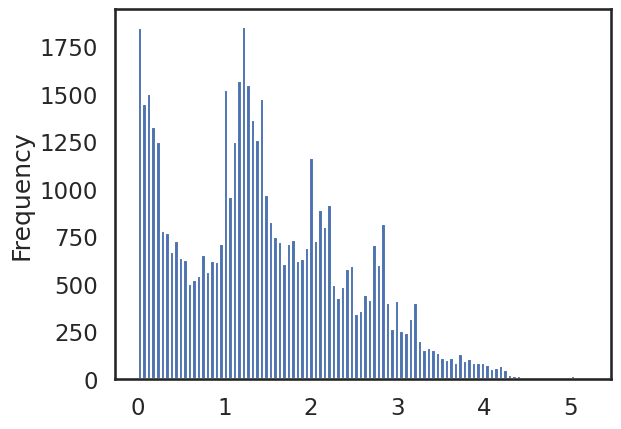

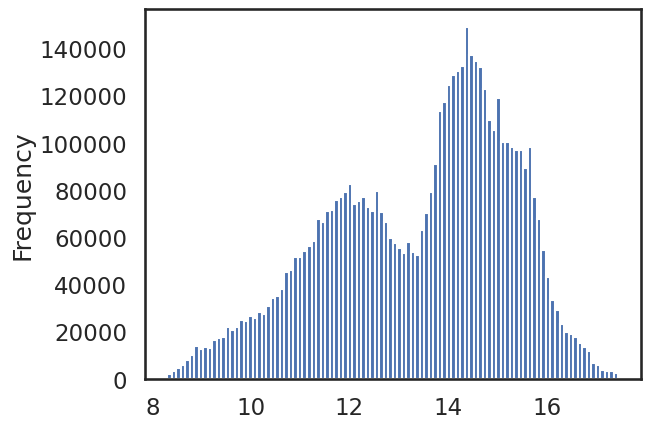

In [7]:
%matplotlib inline
age_ranges = df.groupby('studentId').age.apply(lambda x: x.max() - x.min())
fig = plt.figure()
age_ranges.plot.hist(bins=100)
plt.show()

fig = plt.figure()
df.age.plot.hist(bins=100)
age_ranges = df.groupby('studentId').age.apply(lambda x: x.max() - x.min())

plt.show()

77.0

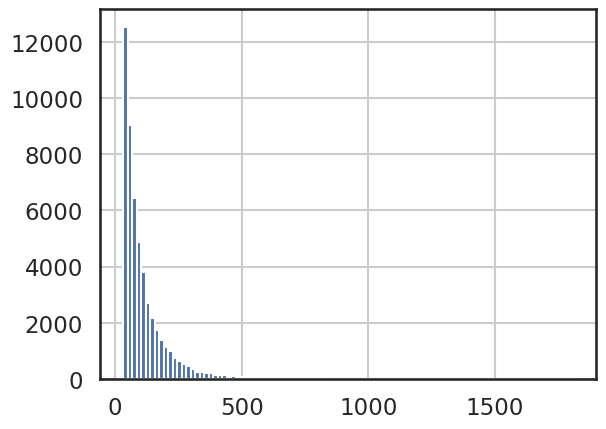

In [8]:
# different items per student
df.groupby(['studentId']).code.nunique().hist(bins=100)
df.groupby(['studentId']).code.nunique().median()

17.0

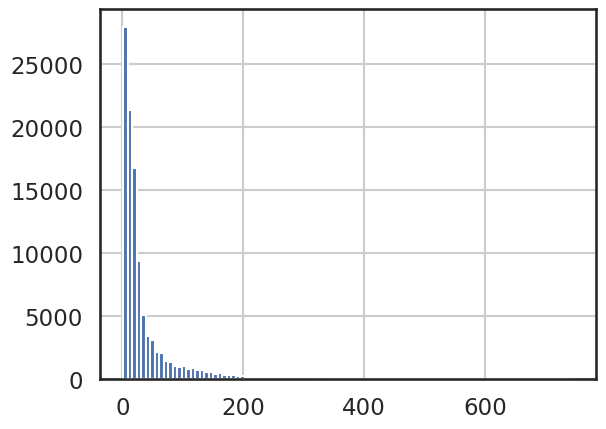

In [9]:
df.groupby(['assessmentId']).code.nunique().hist(bins=100)
df.groupby(['assessmentId']).code.nunique().median()

In [10]:
age_ranges.mean()

1.455946649064223

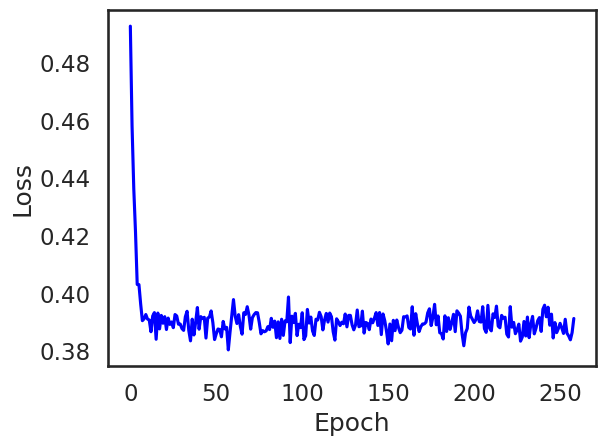

In [11]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()
plt.savefig(f'./vis/{FILENAME}_losses.png', dpi=DPI)

In [12]:
df.head()

,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,textlength,...,timestamp,useCase,assessmentId,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,1.0,0.0,fhoe,F.1.A.1.c.1,-0.370330,Monologe und Dialoge,NaN,NaN,...,7.830814e-312,ms-kber,85007E334A2C9F19ECA408647E6F97139649B1465E15EB...,1.083005,1.851849,2,1.08,,,f
1,0,1,1.0,0.0,fles,F.2.A.1.b.3,-0.494880,Berichte,NaN,NaN,...,7.833807e-312,ms-thema-auto,0D59C4843FFC39195EDE1DD140506CF3DF8BC6F132AAF5...,0.657010,2.727266,3,1.10,,,f
2,0,2,1.0,0.0,mzuv,MA.1.A.3.f,0.368830,Gemischte Grundoperationen,single choice,NaN,...,7.661659e-312,ms-kber,2B0D3CD783DB6BE2341F8CF101395AC464874A993E8CCF...,0.751265,1000000.000000,0,0.00,,,m
3,0,3,1.0,0.0,fhoe,F.1.A.1.d.1,0.367442,Aus TV und Radio,NaN,NaN,...,7.830815e-312,ms-kber,85007E334A2C9F19ECA408647E6F97139649B1465E15EB...,1.083005,1.851849,2,1.08,,,f
4,0,4,1.0,0.0,fles,F.2.A.1.d.1,1.160150,Berichte,NaN,212.0,...,7.833807e-312,ms-thema-auto,0D59C4843FFC39195EDE1DD140506CF3DF8BC6F132AAF5...,0.657010,2.727266,3,1.10,,,f


In [13]:
#np.sum(df.ability.isnull() == False)

In [14]:
myresults.output_stats()

In [15]:
#print(domain_train)
#print(domain_train_rand)
#print(domain_val)

In [16]:
scores_dict = {
    'matrix':{'CH': [], 'SH': [], 'DB':[]},
    'topic':{'CH': [], 'SH': [], 'DB':[]}
    }
distances_dict = {'within': [], 'between': []}
mean_distance_list = []
#NPERMS = 10
# perm == 0 is unshuffled
for perm in range(NPERMS):
    scores_matrix, scores_topic, within_domain, between_domain, mean_distances, unique_scales, within_between_scales = evaluate_items(model, train_data, df_item, device, 
                                                                           shuffle=perm>0, 
                                                                           seed=0, 
                                                                           minsamples=MINSAMPLES)
    [ scores_dict['matrix'][key].append(scores_matrix[key]) for key in scores_dict['matrix']]
    [ scores_dict['topic'][key].append(scores_matrix[key]) for key in scores_dict['topic']]
    distances_dict['within'].append(within_domain)
    distances_dict['between'].append(between_domain)
    mean_distance_list.append(within_between_scales)

dsif    3472
mzuv    3367
mgfz    2512
mfur    1875
dles    1591
esif    1096
eles    1028
fsif    1001
ehoe     879
fles     702
fhoe     345
Name: scale, dtype: int64
dles    345
dsif    345
ehoe    345
eles    345
esif    345
fhoe    345
fles    345
fsif    345
mfur    345
mgfz    345
mzuv    345
Name: scale, dtype: int64


In [23]:
distances_df = pd.DataFrame(np.concatenate(mean_distance_list), columns=unique_scales) 
distances_df['perm'] = distances_df.index // len(unique_scales)
distances_df['random'] = 'Observed data'
distances_df.loc[ distances_df['perm'] > 0, 'random'] = 'Shuffled data'
distances_df['within_between'] = 'between'
distances_df.loc[ distances_df.index % len(unique_scales) == 0, 'within_between'] = 'within'

distances_df = distances_df.groupby(['perm','within_between','random'])[unique_scales].mean().reset_index()
distances_df = pd.melt(distances_df, id_vars=['perm','within_between','random'], value_name='distance', var_name='scale')

# between - within distance should be positive
distances_df['diff'] = distances_df['distance'] 
aux = distances_df.query('`within_between` == "between"').copy().reset_index()
within = distances_df.query('`within_between` == "within"').reset_index()['distance']
aux['diff'] = (aux['diff'] - within)/within*100

distances_df = aux.drop(columns='within_between').sort_values(by=['scale'])

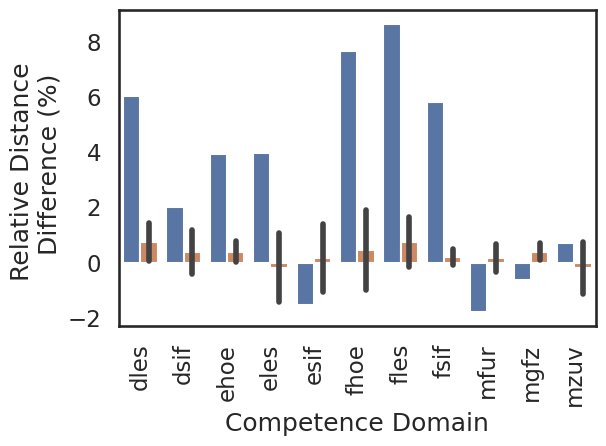

In [24]:
fig = plt.figure()
axes = sns.barplot(data=distances_df, x='scale', y='diff', hue='random', errorbar='sd')
axes.legend_.remove()
axes.tick_params(axis='x', rotation=90)
axes.set(xlabel='Competence Domain', ylabel='Relative Distance \n Difference (%)')
fig.tight_layout()
plt.savefig(f'./vis/{FILENAME}_scale_distance_bw.png', dpi=DPI)

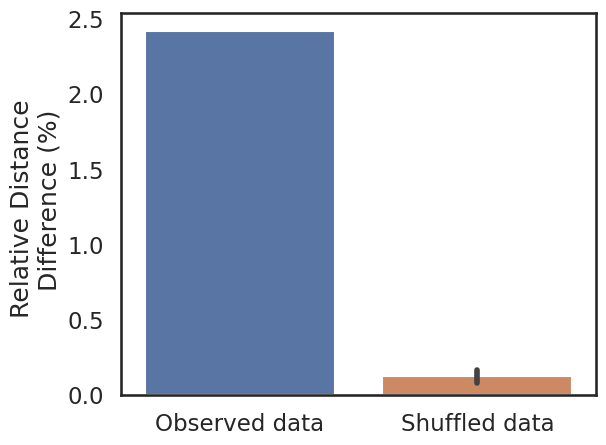

In [19]:
distances_df = pd.DataFrame(distances_dict)
distances_df['perm'] = distances_df.index
#distances_df = pd.melt(distances_df, id_vars='perm', value_name='index', var_name='group')
distances_df['random'] = 'Observed data'
distances_df.loc[ distances_df['perm'] > 0, 'random'] = 'Shuffled data'
distances_df['diff'] = (distances_df['between'] - distances_df['within'] )/distances_df['within']*100
fig = plt.figure()
ax = sns.barplot(data=distances_df, x='random', y='diff', errorbar='sd')
ax.set(xlabel='', ylabel='Relative Distance \n Difference (%)')
fig.tight_layout()

plt.savefig(f'./vis/{FILENAME}_domain_distance_bw.png', dpi=DPI)

In [20]:
#fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#from matplotlib.category import UnitData

for variable in ['matrix', 'topic']:
    for i, index in enumerate(['CH', 'DB']): #scores_dict
        fig = plt.figure(figsize=(FIGSIZE))

        scores_df = pd.DataFrame(scores_dict[variable][index])
        scores_df['perm'] = scores_df.index
        scores_df = pd.melt(scores_df, id_vars='perm', value_name='index', var_name='scale')
        scores_df['random'] = 'Observed data'
        scores_df.loc[ scores_df['perm'] > 0, 'random'] = 'Shuffled data'
        #plt.figure()
        scores_df['scale'] = pd.Categorical(scores_df['scale'], categories=np.sort(scores_df.scale.unique()))
        axes = sns.barplot(data=scores_df, x='scale', y='index', hue='random', errorbar='sd')
        axes.legend_.remove()
        axes.set_xlabel('Competence Domain')
        axes.set_ylabel('Cluster Validity Index Value')
        axes.set_title(CLUSTER_LABELS[index])
        axes.tick_params(axis='x', rotation=90)
        fig.tight_layout()
        plt.savefig(f'./vis/{FILENAME}_{variable}_bw_random_{index}.png', dpi=DPI)
        plt.close()

In [21]:
DIFFICULTY_BINS = 21
df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)

In [22]:
plot_clustering('scalexdifficulty', 'topic', model, val_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)
plot_clustering('scalexdifficulty', 'matrix', model, val_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)
if DATASET in ['matrix', 'topic']:
    sys.exit()

/home/garben/Modelling-Students-Learning/vis_utils.py:511: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7fcb8ce7f550> has a label of '_' which cannot be automatically added to the legend.
  fig.legend( labels=['Observed \ndata', '_', '_', 'Shuffled \ndata', 'Significance \nthreshold'],
/home/garben/Modelling-Students-Learning/vis_utils.py:511: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7fcb8736ddf0> has a label of '_' which cannot be automatically added to the legend.
  fig.legend( labels=['Observed \ndata', '_', '_', 'Shuffled \ndata', 'Significance \nthreshold'],
/home/garben/Modelling-Students-Learning/vis_utils.py:511: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7fcb868adfd0> has a label of '_' which cannot be automatically added to the legend.
  fig.legend( labels=['Observed \ndata', '_', '_', 'Shuffled \ndata', 'Significance \nthreshold'],
/home/garben/Modelling-Students-Learning/vis_util

SystemExit: 

/home/garben/anaconda3/tempnets/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3405: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
visualize_items(model, train_data, device, df_item, FILENAME, equal_axes=EQUAL_AXES)

In [ ]:
visualize_students(model, train_data, device, df_student, FILENAME, equal_axes=EQUAL_AXES)

In [ ]:
#visualize_edges(model, train_data, train_edge_indices, device, df, FILENAME, 
#                equal_axes=EQUAL_AXES, with_lines=True, aggregate=True, AGE_THR=AGE_THR)

In [ ]:
#visualize_edges(model, train_data, train_edge_indices, device, df, FILENAME, 
#                equal_axes=EQUAL_AXES, with_lines=False, aggregate=False, AGE_THR=AGE_THR)

ALPHALEVEL=0.05
for i, index in enumerate(scores_dict):
    scores_df = pd.DataFrame(scores_dict[index])
    scores_df['perm'] = scores_df.index     
    scores_df = pd.melt(scores_df, id_vars='perm', value_name='index', var_name=grouping_variable)
    scores_df['random'] = 'Observed data'
    scores_df.loc[ scores_df['perm'] > 0, 'random'] = 'Shuffled data'
    scores_df['scale'] = scores_df['scalexdifficulty'].str.split().str[0]
    scores_df['difficulty_bin'] = scores_df['scalexdifficulty'].str.split().str[1:].str.join(' ')
    scores_df_ = scores_df.dropna().copy()
    #print(scores_df_.to_string())
    
    fig, axes = plt.subplots(ncols=6, nrows=2, figsize=FIGSIZE, sharex=False, sharey=True)
    
    for i, scale in enumerate(scores_df['scale'].unique()):
        ax = plt.subplot(2, 6, i+1)
        scores_df = scores_df_.loc[ scores_df_['scale'] == scale, :]
        #print(scores_df)
        maxscore_df = scores_df.groupby(['perm','random','difficulty_bin'])['index'].max().reset_index()
        #print(maxscore_df)
        vals = maxscore_df.loc[maxscore_df.random == 'Shuffled data']['index']
        thr = np.quantile(vals, 1 - ALPHALEVEL)
        ax1 = sns.lineplot(ax=ax, data=scores_df.query('`random` == "Observed data"'), #.sort_values('index'), 
                     x=grouping_variable, y='index', 
                     color='black')
        ax2 = sns.scatterplot(ax=ax, data=scores_df.query('`random` == "Shuffled data"'), x=grouping_variable, y='index',
                        hue='random', s=3, alpha=0.5) # + ' ' + target_variable + ' ' + index)
        ax.set_title(scale)
        ax.set_xlabel('Difficulty')
        ax.set_ylabel('Cluster Validity Index Value')
        #axes.set_title(f' {COMPETENCE_LABELS[target_variable]} - {CLUSTER_LABELS[index]}')
        #ax.set_title(f' {COMPETENCE_LABELS[target_variable]} - {CLUSTER_LABELS[index]}')
        ax.axhline(thr, color = 'red', linestyle='--')
        #axes[i].tick_params(axis='x', rotation=90)
        ax.set(xticklabels=[])
        #ax.set_ylim(ylims[index])
        #handles, labels = axes.get_legend_handles_labels()
        #axes.legend(handles=handles[1:], labels=labels[1:])

        h1, _ = ax1.get_legend_handles_labels()
        h2, _ = ax2.get_legend_handles_labels()
        ax.legend_.remove()
        ax.label_outer()
    

    fig.legend( labels=['Observed \ndata', '_', '_', 'Shuffled \ndata', 'Significance \nthreshold'], 
               loc=(0.84, 0.2), fontsize=13)
    ax = plt.subplot(2, 6, 12)
    ax.axis('off')
    
        
    fig.tight_layout()
#    plt.savefig(f'./vis/{OUTNAME}_{grouping_variable}_{target_variable}_clustering_{index}.png')
    plt.savefig(f'./vis/{FILENAME}_{grouping_variable}_{target_variable}_clustering_{index}.png')
    plt.close()

scores_dict = {'CH': [], 'DB':[]}
grouping_variable = 'scalexdifficulty'
target_variable = 'matrix'

minsamples=1
from cluster_utils import compute_clustering_indices
nperms=NPERMS
for perm in range(nperms):
    #print(perm)
    scores = compute_clustering_indices(model, data, df_item, device, grouping_variable, 
                                        target_variable, shuffle=perm>0, seed=0, minsamples=minsamples)
    [ scores_dict[key].append(scores[key]) for key in scores_dict]

#fig, axes = plt.subplots(1, 2, figsize=(16, 6))

%matplotlib inline 
EQUAL_AXES = False
ALPHA = 0.6
FIGSIZE2 = (12, 6)

visualize_edges_age(model, train_data, train_edge_indices, device, df, OUTNAME , equal_axes=EQUAL_AXES, 
                             age_window=(8, 11), aggregate=True, hue_label='motherTongue', with_lines=True, save=False)        

visualize_edges_age(model, train_data, train_edge_indices, device, df, OUTNAME, equal_axes=EQUAL_AXES, 
                             age_window=(8, 13), aggregate=True, hue_label='age', with_lines=True, save=False)        

visualize_edges_age(model, train_data, train_edge_indices, device, df, OUTNAME, equal_axes=EQUAL_AXES, 
                             age_window=(11, 18), aggregate=True, hue_label='age', with_lines=True, save=False)